# pyODV

---

## Overview
Ocean Data Viewer is a nifty piece of software for visualizing gridded data like the World Ocean Atlas. This notebook provides tips about how to make similar plots as part of a Python based workflow. 

---

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import os
import pandas as pd
import seaborn as sns
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

In [128]:
lat_u = r'$^{\circ}$N'
lon_u = r'$^{\circ}$E'
depth_u = 'm'
time_u = 'ky BP'
eNd_label = r'$\varepsilon$Nd'

surface_title = 'depth={} '+depth_u+ ', time={} '+time_u


## Load Data

To run this notebook, you'll need to point it to relevant data files. This notebook assumes files in which TLAT and TLONG are arrays of latitude and longitude values, and that z_t is a depth vector. 

In [3]:
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [4]:
file_name = 'ctrace.decadal.ND143.nc'
ds_Nd143 = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.ND144.nc'
ds_Nd144 = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.SALT.nc'
ds_sal = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.CISO_DIC_d13C.nc'
ds_d13C = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)


In [5]:
time_slice = slice(-8, -5)
ds_Nd143_sub = ds_Nd143.sel(dict(time=time_slice)).copy()
ds_Nd144_sub = ds_Nd144.sel(dict(time=time_slice)).copy()
ds_sal_sub = ds_sal.sel(dict(time=time_slice)).copy()
ds_d13C_sub = ds_d13C.sel(dict(time=time_slice)).copy()

Pull all of the tracer arrays into a single dataset.

In [6]:
iso_ds = xr.combine_by_coords([ds_sal_sub['SALT'].astype(np.float64), 
                               ds_d13C_sub['CISO_DIC_d13C'].astype(np.float64), 
                               ds_Nd144_sub['ND144'].astype(np.float64), 
                               ds_Nd143_sub['ND143'].astype(np.float64)])


Extract a small slice to make things more manageable..

In [7]:
time_slice = slice(-8, -5)
iso_ds_sub = iso_ds.sel(dict(time=time_slice)).copy()

Calculate $\varepsilon$Nd, add it to our mega-dataset and drop Nd-144 and Nd-143.

In [8]:
def epsNd(Nd):
    (Nd143, Nd144) = Nd
    Nd_CHUR = 0.512638
    scaler = 1000
    return (np.divide(Nd143,Nd144)*1/Nd_CHUR-1)*10**4


In [9]:
epsNd_tmp = xr.apply_ufunc(epsNd, (iso_ds['ND143'],iso_ds['ND144']))
epsNd_tmp.name = 'eNd'
iso_ds['eNd'] = (('time', 'z_t', 'nlat', 'nlon'), epsNd_tmp.squeeze().data)
iso_ds = iso_ds.drop_vars(['ND143', 'ND144']).squeeze()

/Users/jlanders/opt/miniconda3/envs/paleobook-dev/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [10]:
def convert_z_to_meters(ds):
    cm_to_m = 1/100
    z_t = ds.z_t.data
    ds['z_t_m'] = ("z_t", z_t*cm_to_m)
    ds = ds.swap_dims({'z_t':'z_t_m'})
    return ds

In [11]:
# convert depth from cm to m
iso_ds =convert_z_to_meters(iso_ds)
iso_ds

<xarray.Dataset>
Dimensions:        (nlat: 116, nlon: 100, time: 301, z_t_m: 60)
Coordinates:
    TLAT           (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG          (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
  * time           (time) float64 -8.0 -7.99 -7.98 -7.97 ... -5.02 -5.01 -5.0
    z_t            (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m          (z_t_m) float32 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon
Data variables:
    CISO_DIC_d13C  (time, z_t_m, nlat, nlon) float64 nan nan nan ... nan nan nan
    SALT           (time, z_t_m, nlat, nlon) float64 nan nan nan ... nan nan nan
    eNd            (time, z_t_m, nlat, nlon) float64 nan nan nan ... nan nan nan

In [12]:
time = 5.99
iso_snapshot_data = iso_ds.sel(time = -time, method='nearest')
# iso_snapshot_data = iso_snapshot_data.compute()

## Surface: lon v. lat + color
A surface plot looks the geographic distribution of some variable on a plane. Here, we'll limit our area of interest to part of the Atlantic and pick a constant depth surface.

In [13]:
def between(ds, var, lims):
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

In [40]:
lonlims = [290, 360]
lon_ds = between(iso_snapshot_data, 'TLONG', lonlims)
latlims = [-90, 90]
subarea_ds = between(lon_ds, 'TLAT', latlims)


In [149]:
var = 'SALT'
colorbar_units='PSU'
depth = 500

In [16]:
iso_snapshot_data[var] =iso_snapshot_data[var].compute()#data.max()

In [30]:
surf_ds = subarea_ds.sel(z_t_m=depth, method='nearest')
c_snapshot_data_surf = surf_ds[var].squeeze()
c_snapshot_data_surf = c_snapshot_data_surf.compute()

Doesn't hurt to take a quick look a the distribution of the data. Particularly given we will want to use a colorbar, it's handy to check in on the range and density of values.

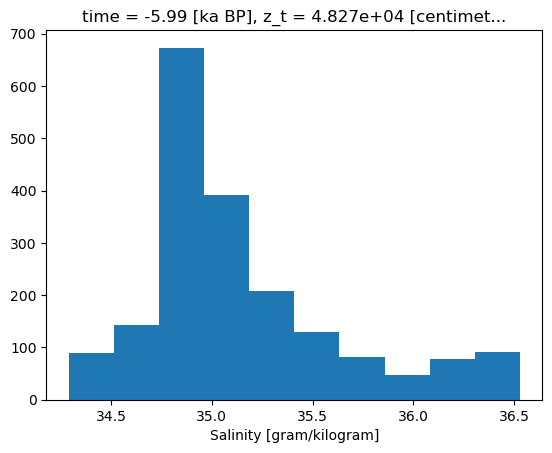

In [22]:
bins =surf_ds[var].compute().plot.hist()
bin_edges = bins[1]

And now for the plot! There aren't any raging outliers, so we'll build our color mapping based on the full range of data.

In [23]:
# establish scale
max_lim = bin_edges[-1]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [24]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if type(cmap)==list:
        if n is None:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
        else:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"], N=n)
    else:
        if n is None:
            ax_cmap = plt.get_cmap(cmap)
        else:    
            ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [25]:
n_levels= 20
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)
# make scalar mappable
ax2_sm = make_scalar_mappable([min_lim, max_lim],'cividis' , n_levels)
cf2_kwargs = {'cmap':ax2_sm.cmap,'levels':ax2_levels, 'norm' : ax2_sm.norm}

As discussed a bit in the notebook about the perils of model grids, there are a few ways to go about plotting spatial distributions. `pcolormesh` takes meshes of x and y values (in our case longitude and latitude) that underpin the data of interest (they do not need to fall on a regular rectangular grid) and interpolates between them.

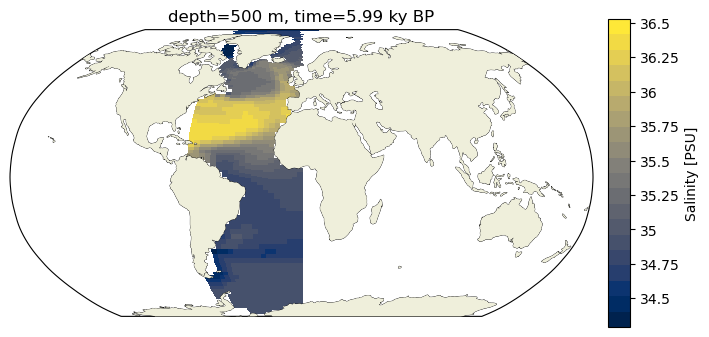

In [154]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label='{} [{}]'.format('Salinity',colorbar_units),
                   format=FormatStrFormatter('%g'))

ax2.set_title(surface_title.format(depth, time));

Alternatively, we can also just make a scatterplot, which has the advantage of making the point density explicity.

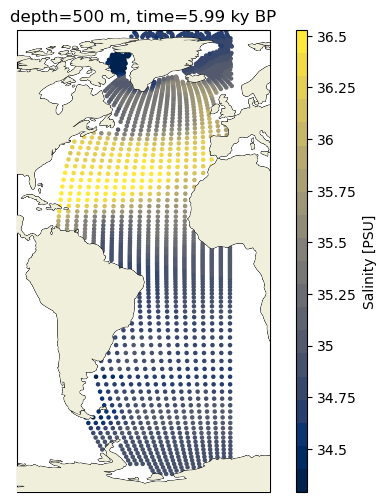

In [151]:
fig = plt.figure(figsize=(4, 6))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

ax2.scatter(c_snapshot_data_surf.TLONG,c_snapshot_data_surf.TLAT,c=c_snapshot_data_surf, 
            transform=ccrs.PlateCarree(), 
            cmap=cf2_kwargs['cmap'], 
            norm=cf2_kwargs['norm'], 
             s=5)

ax2.set_extent([lonlims[0]-15,lonlims[1]+15, latlims[0], latlims[1]], crs=ccrs.PlateCarree())
ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label='Salinity [{}]'.format(colorbar_units),
                   format=FormatStrFormatter('%g'))
ax2.set_title(surface_title.format(depth, time));

## Section: lat or lon v. depth
A section plot is a depth transect in which the x axis reflects a distance metric (latitude or longitude in this case), the y axis is depth with some variable plotted as color.  Here we will plot the data as a scatterplot, and then as filled contour plot. The calculations involved in producing filled contour plots require the data be more regular. because we are selecting data along a line of longitude, we can describe our coordinates with a vector of latitude values and a vector of depth values--the true tenants of a grid! 

As a nice bit of convenience, we introduce an inset map that makes it easier to contextualize the depth transect.

In [33]:
lims = [340, 342]
_sect_ds = between(subarea_ds, 'TLONG', lims)
sect_ds = _sect_ds[var].squeeze()
sect_ds = sect_ds.compute()

lat_lims = [min(sect_ds.TLAT.mean(dim='nlon')), max(sect_ds.TLAT.mean(dim='nlon'))]
lon_lims = np.mean(lims)*np.ones(2)

In [34]:
def make_inset_map(ax, lats, lons, central_lon=0,central_lat=0):
    axin = inset_axes(ax, width=.25*5, height=.25*5, loc="lower right", 
                 axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(projection=ccrs.Orthographic(central_latitude=central_lat, 
                                                               central_longitude=central_lon)))
                                                               # central_lon)))

    axin.coastlines(linewidth=.5)
    axin.add_feature(cfeature.LAND, zorder=14)
    axin.plot(lons, lats, transform=ccrs.PlateCarree())
    axin.set_global()


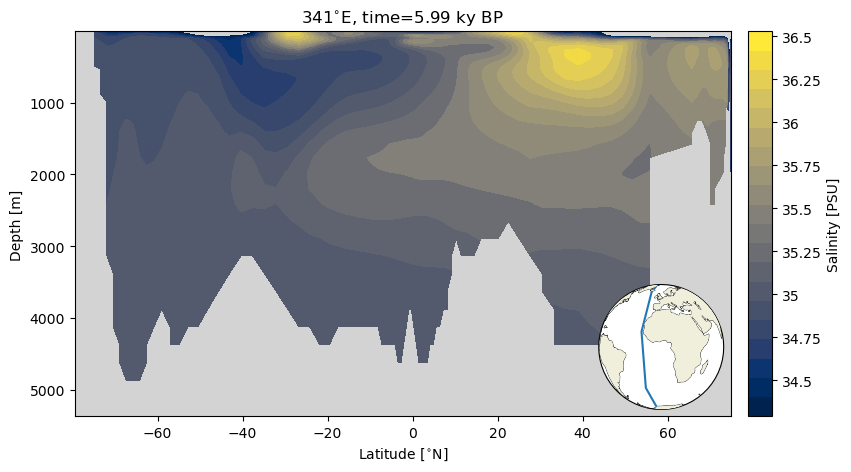

In [147]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
ax.patch.set_facecolor('lightgray')

ax.contourf(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m,
                     sect_ds.mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)


ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [{}]'.format(lat_u))

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label='Salinity [{}]'.format(colorbar_units),
                   format=FormatStrFormatter('%g'))

make_inset_map(ax, lat_lims, lon_lims, central_lon=0,central_lat=0)
ax.set_title('{}{}, time={} {}'.format(341,lon_u, time, time_u));

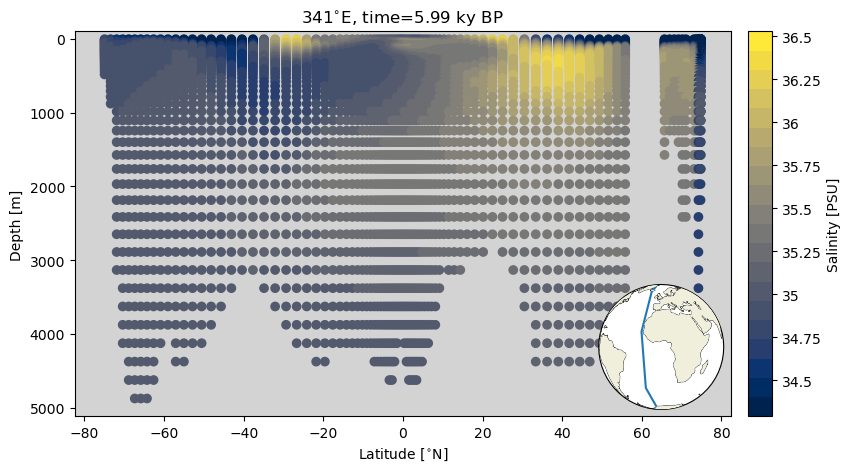

In [156]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# background color
ax.patch.set_facecolor('lightgray')

# for scatter, because color var is an array, need to make a mesh version of x and y vars
lat_mesh, depth_mesh = np.meshgrid(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m)
ax.scatter(lat_mesh,depth_mesh,
                     c=sect_ds.mean(dim='nlon').squeeze().data,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)


ylims = ax.get_ylim()
ax.set_ylim([ylims[1], max([-100,ylims[0]])])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [{}]'.format(lat_u))

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label='Salinity [{}]'.format(colorbar_units),
                   format=FormatStrFormatter('%g'))

make_inset_map(ax, lat_lims, lon_lims, central_lon=0,central_lat=0)
ax.set_title('{}{}, time={} {}'.format(341,lon_u, time, time_u));

## Profile: var 1 v. depth
Last plot type!  We are frequently interested in how some variable changes with depth. This is a little simpler on a regular grid when it is possible to query by dimensions. Instead, we'll get as close as we can and then take the mean latitude-wise and then longitude-wise so we are left with a depth profile. 

In [192]:
lims = [340, 342]
_sect_ds = between(subarea_ds, 'TLONG', lims)
lims = [40, 42]
prof_reg = between(_sect_ds['SALT'].squeeze(), 'TLAT', lims)
prof_reg = prof_ds.compute()

In [193]:
lat = prof_reg.TLAT.mean(dim='nlon')
lon = prof_reg.TLONG.mean(dim='nlat')
prof = prof_reg.mean(dim='nlat').mean(dim='nlon')
prof_df = pd.DataFrame({'values': prof.data, 'label': ['prof_1' for ik in range(len(prof.data))], 'depth': prof.z_t_m.data})

Text(0.5, 0, 'salinity (psu)')

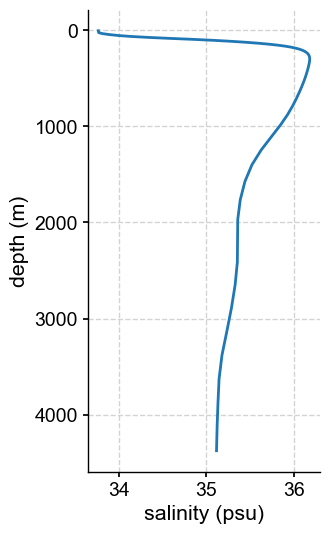

In [196]:
fig = plt.figure(figsize=(3,6));
ax = fig.add_subplot();

ax.plot('values', 'depth', data=prof_df)
ax.invert_yaxis()
ax.set_ylabel('depth (m)')
ax.set_xlabel('salinity (psu)')

## Scatter: var1 v. var2 (colored by var3)
While we have discussed scatter plots before, let's have a quick look at the case in which the x and y values are variable rather than positional.  

Seaborn is such user friendly tool for this sort of thing that it is silly not to leverage it. That said, it doesn't take in xarray datasets (yet!), so we'll need to do a little data restructuring. 

It appears (as far as this author can tell), that filtering an xarray dataset applies a mask to the array, but does not filter the scope of the coordinates. For illustrative purposes, we want to have latitude, longitude and depth available as variables so we need to cajol them into the same shape as, for example, SALT. 

1. make longitude, latitude and depth arrays that each have the same three dimensional size (corresponding to the dimensions of the target variable, e.g., SALT)

In [55]:
longmesh = np.array([_sect_ds.TLONG.data for ik in range(len(_sect_ds.z_t_m))])
latmesh = np.array([_sect_ds.TLAT.data for ik in range(len(_sect_ds.z_t_m))])
depthmesh = np.array([depth*np.ones_like(_sect_ds.TLONG.data) for depth in _sect_ds.z_t_m.data])

2. build a boolean filter to identify the nan values in the SALT array (these correspond to landmasses and the data that were masked earlier because they didn't fall on the line of longitude we specified)

In [56]:
nan_filter = np.isnan(_sect_ds['SALT'].data)

3. filter all arrays with the `.isnan()` filter

In [57]:
filtered_salt = _sect_ds['SALT'].data[~nan_filter]
filtered_eNd = _sect_ds['eNd'].data[~nan_filter]

filtered_lon = longmesh[~nan_filter]
filtered_lat = latmesh[~nan_filter]
filtered_depth = depthmesh[~nan_filter]

4. package all these neatly constructed arrays into a dataframe!

In [63]:
sect_df = pd.DataFrame({'salt':filtered_salt.ravel(),'eNd':filtered_eNd.ravel(),
                   'lon':filtered_lon.ravel(),
                   'lat':filtered_lat.ravel(), 'depth':filtered_depth.ravel()})


Text(0.5, 0, 'Salinity [PSU]')

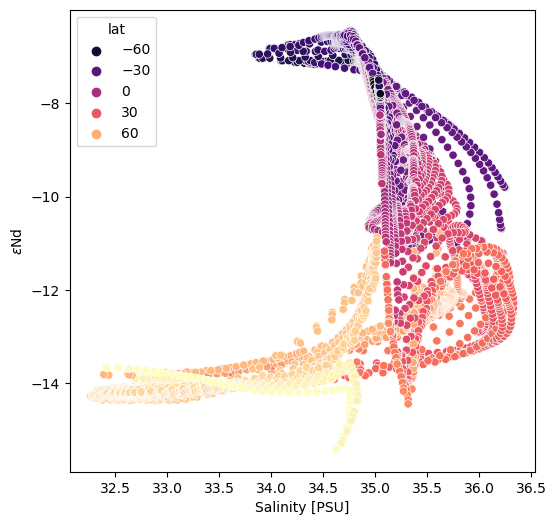

In [135]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
sns.scatterplot(x='salt', y='eNd', hue='lat', data=sect_df, palette='magma')
ax.set_ylabel(eNd_label)
ax.set_xlabel('Salinity [PSU]')

In [68]:
surf_df = pd.DataFrame({'lon': surf_ds.TLONG.data.ravel(), 'lat': surf_ds.TLAT.data.ravel(), 'eNd': surf_ds['eNd'].data.ravel(), 'salt': surf_ds['SALT'].data.ravel()})
surf_df = surf_df.dropna()

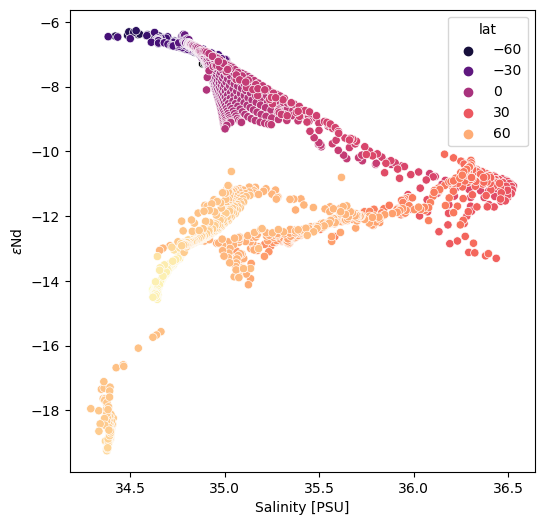

In [134]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
sns.scatterplot(x='salt', y='eNd', hue='lat', data=surf_df, palette='magma', ax=ax)
ax.set_ylabel(eNd_label)
ax.set_xlabel('Salinity [PSU]');

## Dashboard
Finally, we can pull all of these elements together in a dashboard. 

Text(0.8, 0.18, 'Surface\n500m')

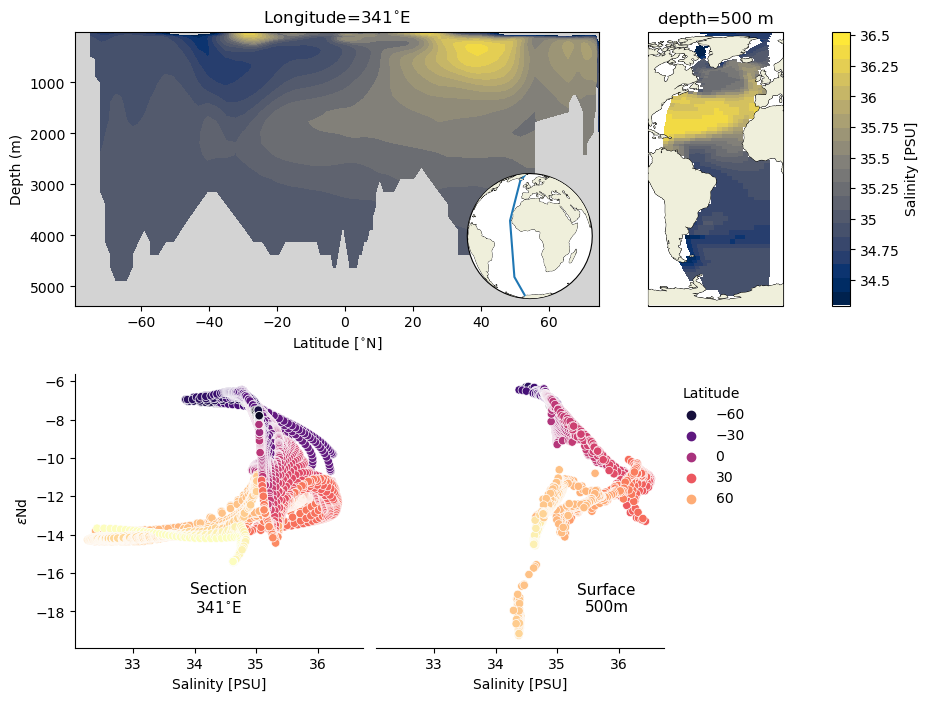

In [131]:
fig = plt.figure(figsize=(10,8));
gs0 = fig.add_gridspec(2, 1, hspace=.25)

gs1 = gs0[0].subgridspec(1, 3, wspace=0, width_ratios=[9, 4,.3])
sect_ax = fig.add_subplot(gs1[0])
surf_ax = fig.add_subplot(gs1[1], projection=ccrs.Robinson(central_longitude=0))
cb_sal = fig.add_subplot(gs1[2])

# section plot
sect_ax.patch.set_facecolor('lightgray')
sect_ax.contourf(sect_ds.TLAT.mean(dim='nlon'), sect_ds.z_t_m,
                     sect_ds.mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)


ylims = sect_ax.get_ylim()
sect_ax.set_ylim([ylims[1], max([-100,ylims[0]])])
sect_ax.set_ylabel('Depth (m)')
sect_ax.set_xlabel('Latitude [{}]'.format(lat_u))
sect_ax.set_title('Longitude=341{}'.format(lon_u))

make_inset_map(sect_ax, lat_lims, lon_lims, central_lon=0,central_lat=0)

# surface plot
c_snapshot_data_surf.plot.pcolormesh(ax=surf_ax, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False);

surf_ax.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
surf_ax.set_extent([lonlims[0]-10,lonlims[1]+10, latlims[0], latlims[1]], crs=ccrs.PlateCarree())
surf_ax.coastlines(linewidth=.5)
surf_ax.add_feature(cfeature.LAND, zorder=14)
surf_ax.set_title('depth=500 m')

# colorbar
cb2 = plt.colorbar(ax2_sm,cax=cb_sal, orientation='vertical',label='Salinity [{}]'.format(colorbar_units),
                   format=FormatStrFormatter('%g'))

# scatter plots
gs2 = gs0[1].subgridspec(1, 3, wspace=0.05, width_ratios=[5, 5, 3])
sect_scatter_ax = fig.add_subplot(gs2[0])
surf_scatter_ax = fig.add_subplot(gs2[1], sharex=sect_scatter_ax)
sns.scatterplot(x='salt', y='eNd', hue='lat', data=surf_df, ax=surf_scatter_ax, palette='magma')
sns.scatterplot(x='salt', y='eNd', hue='lat', data=sect_df, ax=sect_scatter_ax, palette='magma',legend=False)
surf_scatter_ax.legend(title='Latitude',frameon=False,bbox_to_anchor=(1,1), loc="upper left")

ylims = surf_scatter_ax.get_ylim()
sect_scatter_ax.set_ylim(ylims)

surf_scatter_ax.spines['right'].set_visible(False)
sect_scatter_ax.spines['right'].set_visible(False)
surf_scatter_ax.spines['top'].set_visible(False)
sect_scatter_ax.spines['top'].set_visible(False)
surf_scatter_ax.spines['left'].set_visible(False)

surf_scatter_ax.set_yticks([])
surf_scatter_ax.set_ylabel('')
sect_scatter_ax.set_ylabel(eNd_label)
surf_scatter_ax.set_xlabel('Salinity [PSU]')
sect_scatter_ax.set_xlabel('Salinity [PSU]')

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

sect_scatter_ax.text(0.5*(left+right), 0.18*(bottom+top), 'Section\n341{}'.format(lon_u),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=11, color='black',
        transform=sect_scatter_ax.transAxes)

surf_scatter_ax.text(0.8*(left+right), 0.18*(bottom+top), 'Surface\n500m',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=11, color='black',
        transform=surf_scatter_ax.transAxes)


---

## Summary
There are a myriad of ways to combine these plots to build a story, but these examples should serve as solid starting points for each figure type. 

## Resources and references

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Gu, Sifan, Liu, Zhengyu, Jahn, Alexandra, Zanowski, Hannah. (2021). C-iTRACE. Version 1.0. UCAR/NCAR - DASH Repository. https://doi.org/10.5065/hanq-bn92. 
|Schlitzer, Reiner, Ocean Data View, odv.awi.de, 2023.